<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [17]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [18]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [19]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [20]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



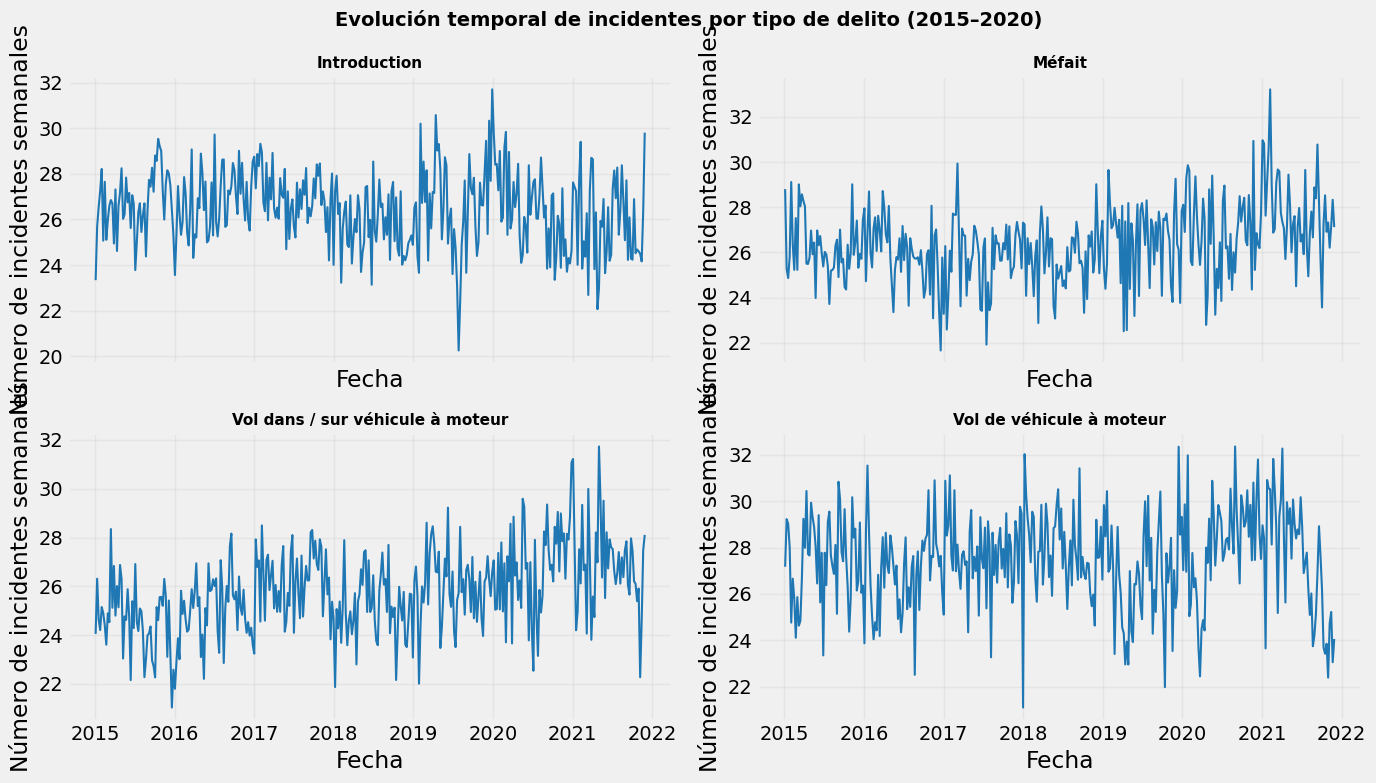

In [21]:
# Visualización de las series temporales por categoría

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
series = [y_s1, y_s2, y_s3, y_s4]
titles = validate_categorie

for i, ax in enumerate(axes.flatten()):
    ax.plot(series[i].index, series[i]['pdq'], color='tab:blue', linewidth=1.5)
    ax.set_title(titles[i], fontsize=11, fontweight='bold')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Número de incidentes semanales')
    ax.grid(alpha=0.3)

plt.suptitle('Evolución temporal de incidentes por tipo de delito (2015–2020)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()




1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [22]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
13,1.7336,4.4704,2.1143,0.0681,0.0677,0.0670,0.0655,0.0669,"SARIMA_(0,0,1)X(1,0,1,52)"
37,1.7398,4.4759,2.1156,0.0682,0.0679,0.0672,0.0656,0.0671,"SARIMA_(1,0,0)X(1,0,1,52)"
5,1.7327,4.4857,2.1179,0.0681,0.0678,0.0670,0.0655,0.0668,"SARIMA_(0,0,0)X(1,0,1,52)"
45,1.7586,4.5359,2.1298,0.0680,0.0677,0.0680,0.0655,0.0680,"SARIMA_(1,0,1)X(1,0,1,52)"
57,1.7325,4.7111,2.1705,0.0646,0.0643,0.0670,0.0622,0.0671,"SARIMA_(1,1,1)X(0,0,1,52)"


Mejor modelo: SARIMA_(0,0,1)X(1,0,1,52)


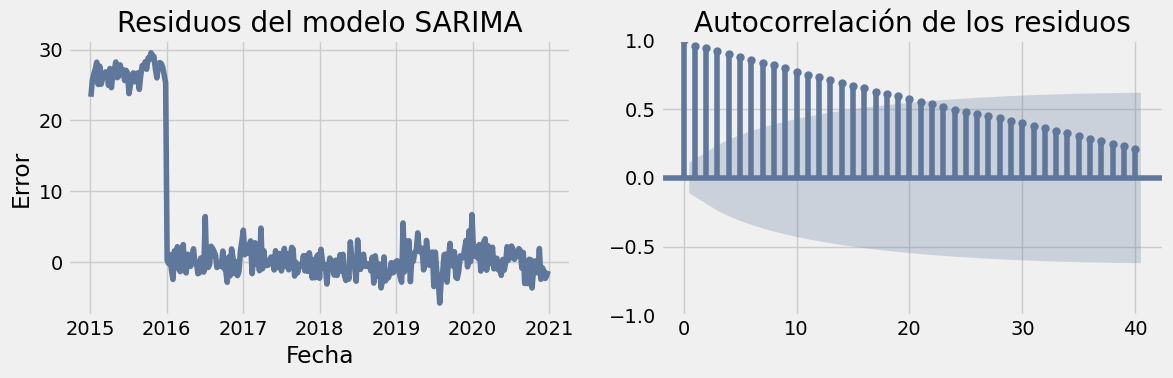

        lb_stat  lb_pvalue
10  2424.227224        0.0
20  3881.260986        0.0
30  4662.879263        0.0
count    313.000000
mean       4.481230
std       10.096357
min       -5.769107
25%       -1.004368
50%        0.404241
75%        2.179670
max       29.532447
dtype: float64


In [23]:
import itertools, re
from statsmodels.stats.diagnostic import acorr_ljungbox

y = y_s1.copy()
target_date = '2021-01-01'

p = d = q = range(0, 2)                      # {0,1}
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(P, D, Q, 52)
                for P, D, Q in itertools.product(p, d, q)]
params = list(itertools.product(pdq, seasonal_pdq))

# BÚSQUEDA DE MODELOS Y MÉTRICAS
results = []
for param in params:
    try:
        model = SarimaModels(param)
        df_metrics = model.metrics(y, target_date)
        results.append(df_metrics)
    except Exception as e:
        continue

df_results = pd.concat(results, ignore_index=True).sort_values('rmse')
display(df_results.head())

# TOMAR EL MEJOR MODELO AUTOMÁTICAMENTE
best_model_str = df_results.iloc[0]['model']
print("Mejor modelo:", best_model_str)

m = re.search(r"SARIMA_\((\d+),(\d+),(\d+)\)X\((\d+),(\d+),(\d+),(\d+)\)", best_model_str)
p,d,q,P,D,Q,s = map(int, m.groups())
best_params = ((p,d,q), (P,D,Q,s))

# AJUSTE FINAL Y VALIDACIÓN DE RESIDUOS
best_model = SarimaModels(best_params)
model_fit = best_model.fit_model(y, target_date)

residuals = model_fit.resid

# Gráficos de diagnóstico
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(x=residuals.index, y=residuals, ax=axes[0])
axes[0].set_title("Residuos del modelo SARIMA")
axes[0].set_xlabel("Fecha"); axes[0].set_ylabel("Error")

sm.graphics.tsa.plot_acf(residuals.dropna(), lags=40, ax=axes[1])
axes[1].set_title("Autocorrelación de los residuos")
plt.tight_layout(); plt.show()

lb = acorr_ljungbox(residuals.dropna(), lags=[10,20,30], return_df=True)
print(lb)

# Resumen de residuos
print(residuals.describe())



Se seleccionó la serie Introduction y se ajustaron múltiples modelos SARIMA con estacionalidad semanal anual (S=52). El mejor desempeño en el conjunto de test, según RMSE, se obtuvo con SARIMA(0,0,1)×(1,0,1,52).
Sin embargo, la validación de residuos (ACF y test de Ljung–Box) indica autocorrelación remanente (p-values ≈ 0), por lo que no se comportan como ruido blanco. Esto sugiere que el modelo no captura completamente la dinámica; una mejora plausible es incluir diferenciación estacional (D=1) y/o diferenciación no estacional (d=1) y reevaluar.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [24]:

!pip install prophet --upgrade --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 78.9 MB/s eta 0:00:00


      mae     mse    rmse   mape   maape  wmape   mmape  smape   modelo
0  1.7079  4.1305  2.0324  0.067  0.0667  0.066  0.0645  0.066  Prophet


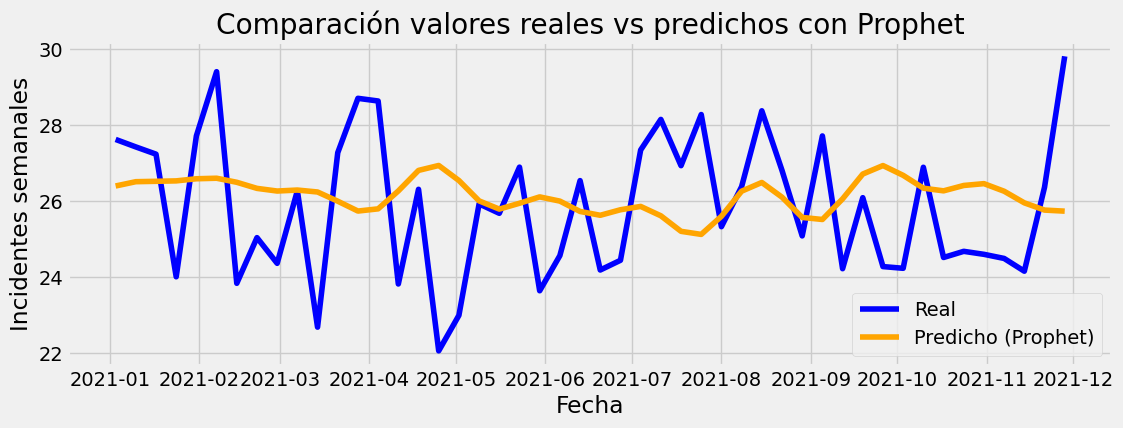

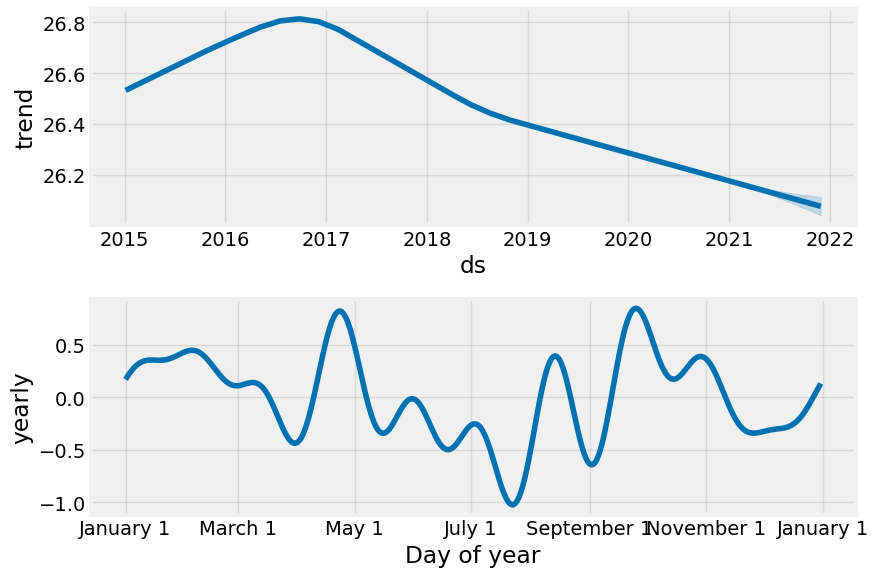

In [26]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

y = y_s1.copy()

datos = y.reset_index()
datos = datos.rename(columns={'date': 'ds', 'pdq': 'y'})

train = datos[datos['ds'] < '2021-01-01']
test = datos[datos['ds'] >= '2021-01-01']

modelo = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

modelo.fit(train)

futuro = modelo.make_future_dataframe(periods=len(test), freq='W')

pred = modelo.predict(futuro)

pred_test = pred.set_index('ds').loc[test['ds'], 'yhat']

df_res = pd.DataFrame({'real': test['y'].values, 'predicho': pred_test.values})

resumen = summary_metrics(df_res.rename(columns={'real':'y','predicho':'yhat'}))
resumen['modelo'] = ['Prophet']
print(resumen)

plt.figure(figsize=(12,4))
plt.plot(test['ds'], test['y'], label='Real', color='blue')
plt.plot(test['ds'], pred_test, label='Predicho (Prophet)', color='orange')
plt.title('Comparación valores reales vs predichos con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Incidentes semanales')
plt.legend()
plt.grid(True)
plt.show()

modelo.plot_components(pred)
plt.show()




Se entrenó un modelo Prophet usando la misma serie que en SARIMA, considerando solo estacionalidad anual.
El modelo mostró una tendencia general decreciente y una estacionalidad clara durante el año.

En cuanto al desempeño, obtuvo MAE = 1.70 y RMSE = 2.03, levemente mejores que los de SARIMA, aunque con una curva de predicción más suave.

Comparando ambos métodos, Prophet es más simple y rápido de implementar, mientras que SARIMA permite un control más detallado sobre los parámetros.

En conclusión, Prophet es recomendable cuando se busca facilidad y rapidez, y SARIMA cuando se necesita mayor precisión y ajuste al comportamiento real de la serie.


